<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

<img style="float:left" src="https://storage.googleapis.com/kaggle-datasets-images/1340957/2232033/07afd86ad776c810d846ec025b6681a2/dataset-cover.jpg?t=2021-05-17-21-12-23" />

* [Description](#0)
* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Search for Spark Installation](#1.2)
  * [1.3 Create SparkSession](#1.2)
* [2. Lab](#2)
  * [2.1 Check Lab Files](#2.1)
* [3. Data Preparation](#3)
  * [3.1 Data Cleansing](#3.1)
  * [3.2 Feature Engineering](#3.2)
  * [3.3 Business Questions](#3.3)  
* [4. Model Training](#4)
* [5. Model Evaluation](#5)
* [6. Model Selection](#6)
* [7. Model Persistence](#7)
* [8. Model Loading](#8)

<a id='0'></a>
## Description
<p>
<div>The goal for this lab is:</div>
<ul>    
    <li>Spark's Machine Learning API</li>
</ul>
</p>

The goal is to create a machine learning model to predict if the applicant would get the loan or not, therefore is a classification problem. 
While applying for Loan is a exhausting process for the applicant as well as the bank, it costs to the banks a lot of time and efficinecy. Hence automating the loan eligibility process (real time) based on customer information.

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 
This step is only needed in our course environment; other Spark environments you might see out there, might not need this statement.

In [1]:
import findspark
findspark.init()

In order to improve how data is displayed, I'll setup Pandas accordingly.

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession

Time to create the SparkSession which we'll use to send our Spark code:

In [3]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("Loan Prediction - Analytics - MLlib")
    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<a id='2'></a>
## 2. Lab

<a id='2.1'></a>
### 2.1 Check Lab Files

In order to complete this lab you need to previosly upload the datasets into HDFS.<br/>

Check you have the data ready in HDFS

http://localhost:50070/explorer.html#/datalake/raw/loan

<a id='3'></a>
## 3. Data Preparation

<a id='3.1'></a>
### 3.1 Data Cleansing

In [4]:
Loan_raw = (spark.read
                    .option("inferSchema", "true")
                    .option('header', 'true')
                    .csv("hdfs://localhost:9000/datalake/raw/loan/")
                    .cache())

There are altogether 13 columns in our data set. One of them, Loan_Status is the response variable and rest all are the variables/factors that decide the approval of the loan or not.

Now let us look into each variable and make some assumptions.

**Loan ID** - As the name suggests each person should have a unique loan ID.

**Gender** - In general it is male or female.

**Married** - Applicant who is married is represented by Y and not married is represented as N. The information regarding whether the applicant who is married is divorced or not has not been provided. So we don’t need to worry regarding all these.

**Dependents** - the number of people dependent on the applicant who has taken loan has been provided.

**Education** - It is either non -graduate or graduate. The assumption we make is “ The probability of clearing the loan amount would be higher if the applicant is a graduate”.

**Self_Employed** - As the name suggests Self Employed means , he/she is employed for himself/herself only. So freelancer or having a own business might come in this category. An applicant who is self employed is represented by Y and the one who is not is represented by N.

**Applicant Income** - Applicant Income suggests the income by Applicant.So the general assumption that i can make would be “The one who earns more have a high probability of clearing loan amount and would be highly eligible for loan ”

**Co Applicant income** - this represents the income of co-applicant. I can also assume that “ If co applicant income is higher, the probability of being eligible would be higher “

**Loan Amount** - This amount represents the loan amount in thousands. One assumption I can make is that “ If Loan amount is higher, the probability of repaying would be lesser and vice versa”

**Loan_Amount_Term** - This represents the number of months required to repay the loan.

**Credit_History** - When I googled it , I got this information. A credit history is a record of a borrower’s responsible repayment of debts. It suggests → 1 denotes that the credit history is good and 0 otherwise.

**Property_Area** - The area where they belong to is my general assumption as nothing more is told. Here it can be three types. Urban or Semi Urban or Rural

**Loan_Status** - If the applicant is eligible for loan it’s yes represented by Y else it’s no represented by N.

In [5]:
Loan_raw.limit(20).toPandas()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [6]:
Loan_raw.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



*Exploratory Data Analysis* to understand our data a bit better

In [7]:
Loan_raw.summary().toPandas()

,summary,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,count,614,601,611,599,614,582,614,614,592,600,564,614,614
1,mean,None,None,None,0.5547445255474452,None,None,5403.459283387622,1621.245798027101,146.41216216216216,342.0,0.8421985815602837,None,None
2,stddev,None,None,None,0.7853289861674311,None,None,6109.041673387181,2926.2483692241894,85.58732523570545,65.12040985461255,0.3648783192364052,None,None
3,min,LP001002,Female,No,0,Graduate,No,150,0.0,9,12,0,Rural,N
4,25%,None,None,None,0.0,None,None,2876,0.0,100,360,1,None,None
5,50%,None,None,None,0.0,None,None,3812,1167.0,128,360,1,None,None
6,75%,None,None,None,1.0,None,None,5800,2302.0,168,360,1,None,None
7,max,LP002990,Male,Yes,3+,Not Graduate,Yes,81000,41667.0,700,480,1,Urban,Y


In [8]:
numeric_features = [t[0] for t in Loan_raw.dtypes if t[1] == 'int' or t[1]== 'double']
Loan_raw.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ApplicantIncome,614,5403.459283387622,6109.041673387181,150,81000
CoapplicantIncome,614,1621.245798027101,2926.2483692241894,0.0,41667.0
LoanAmount,592,146.41216216216216,85.58732523570545,9,700
Loan_Amount_Term,600,342.0,65.12040985461255,12,480
Credit_History,564,0.8421985815602837,0.3648783192364052,0,1


Here we do the summary of the datasets excluding all the string columns. 
We can see that there are some null values, a lot of variations in the Income columns and also a few missing rows.

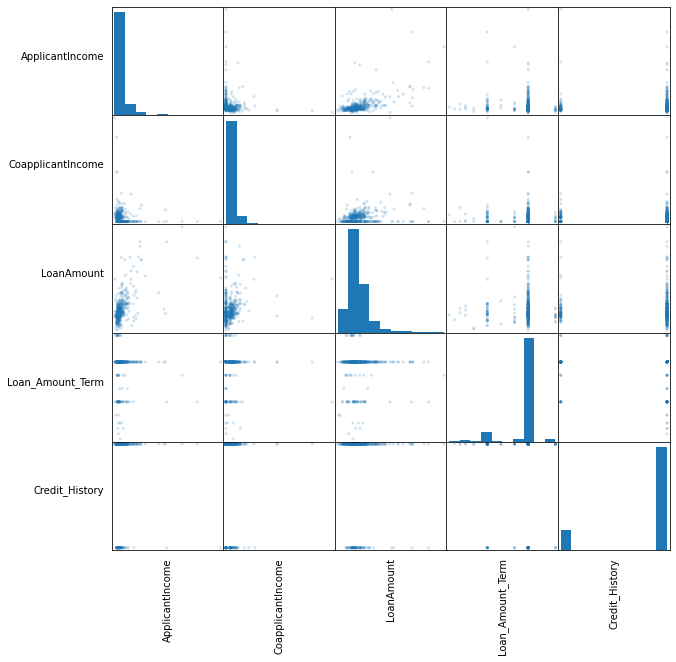

In [9]:
from pandas.plotting import scatter_matrix


numeric_features = [t[0] for t in Loan_raw.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = Loan_raw.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, alpha=0.2, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Let's analize the number of **loan approved**:

In [10]:
Loan_raw.groupBy("Loan_Status").count().toPandas()

,Loan_Status,count
0,Y,422
1,N,192


<a id='3.1.1'></a>
#### 3.1.1 Checking the Nulls

In [11]:
from pyspark.sql.functions import isnull, when, count, col, avg


Loan_raw.select([count(when(isnull(c), c)).alias(c) for c in Loan_raw.columns]).toPandas()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,13,3,15,0,32,0,0,22,14,50,0,0


Here we can see the exact number of Null Values in all the columns. 

**Credit_History** & **Loan_ID**

As credit history has the most number of null values we drop it. Also dropping Loan_ID as it serves as a unique index.

In [12]:
Loan_raw = Loan_raw.drop("Credit_History")
Loan_raw = Loan_raw.drop("Loan_ID")

**Self_Employed**

In [13]:
Loan_raw.groupBy("Self_Employed").count().toPandas()

,Self_Employed,count
0,None,32
1,No,500
2,Yes,82


Filling the null values here by *No* as *No* is almost five times of *Yes*

In [14]:
Loan_raw = Loan_raw.na.fill({"Self_Employed" : 'No'})

**Married**

In [15]:
Loan_raw.groupBy("Married").count().toPandas()

,Married,count
0,None,3
1,No,213
2,Yes,398


As missing values only is 3, filling it with *Yes* as *Yes* is almost double the *No*

In [16]:
Loan_raw = Loan_raw.na.fill({"Married" : 'Yes'})

**Gender**

In [17]:
Loan_raw.groupBy("Gender").count().toPandas()

,Gender,count
0,None,13
1,Female,112
2,Male,489


Filling the null values here by *Male* as almost five times of *Female*

In [18]:
Loan_raw = Loan_raw.na.fill({"Gender" : 'Male'})

**Dependents**

In [19]:
Loan_raw.groupBy("Dependents").count().toPandas()

,Dependents,count
0,0,345
1,None,15
2,1,102
3,3+,51
4,2,101


Here we thought there is no 3, as it could be that in the loan form they dont have a option of 3. Also, applicants can missjudged that.

In [20]:
Loan_raw = Loan_raw.na.fill({"Dependents" : '3'})


<a id='3.1.2'></a>
#### 3.1.2 Checking for Outliers in Numerical Columns

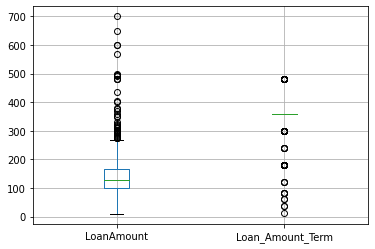

In [21]:
numeric_columns = [column[0] for column in Loan_raw.dtypes if column[1]=='int' or column[1] == 'double' ]
numeric_columns
original_numerical_df = Loan_raw.select(*numeric_columns).toPandas()


import pandas as pd
import matplotlib.pyplot as plt


original_numerical_df.boxplot(column=["LoanAmount", "Loan_Amount_Term"])

plt.show()

Here we can see that there are outliers in *Loan Amont* column. Regarding *Loan_Amount_Term* columns we can say that there are only particular values that can be filled in there.

**LoanAmount**

As there are outliers in the *Loan Amount* column, filling the null values with mean is not an option here. Therefore filling the Null Values with Median.
For that we are calling imputer and doing an imputing function with strategy as 'Median'.

In [22]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols = ['LoanAmount'],
    outputCols = ["{}_imputed".format(a) for a in ['LoanAmount']]
).setStrategy("median")

In [23]:
#calling the Imputer and doint the fit.
ImputedLoanAmountDF=imputer.fit(Loan_raw).transform(Loan_raw)

**Loan_Amount_Term**

In [24]:
Loan_raw.groupBy("Loan_Amount_Term").count().toPandas()

,Loan_Amount_Term,count
0,300.0,13
1,12.0,1
2,360.0,512
3,NaN,14
4,120.0,3
5,84.0,4
6,240.0,4
7,480.0,15
8,60.0,2
9,180.0,44


The values of the *Loan_Amount_Term* is in months and when divided by 12 it gives the Term in Year. For filling the Nan Values here is better to use Mode instead of Median or Mean.

In [25]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols = ['Loan_Amount_Term'],
    outputCols = ["{}_imputed".format(a) for a in ['Loan_Amount_Term']]
).setStrategy("mode")

In [26]:
TotalImputedDF=imputer.fit(ImputedLoanAmountDF).transform(ImputedLoanAmountDF)
TotalImputedDF.toPandas()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area,Loan_Status,LoanAmount_imputed,Loan_Amount_Term_imputed
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,Urban,Y,127,360
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,Rural,N,128,360
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,Urban,Y,66,360
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,Urban,Y,120,360
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,Urban,Y,141,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,Rural,Y,71,360
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,Rural,Y,40,180
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,Urban,Y,253,360
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,Urban,Y,187,360


As for inputed function gives us the extra columns, we need to drop the older columns.

In [27]:
TotalImputedDF.drop('Loan_Amount_Term','LoanAmount') \
    .printSchema()
cols = ('Loan_Amount_Term','LoanAmount')

FinalLoanDF=TotalImputedDF.drop(*cols) 

root
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)
 |-- LoanAmount_imputed: integer (nullable = true)
 |-- Loan_Amount_Term_imputed: integer (nullable = true)



In [28]:
LoanDF=FinalLoanDF
LoanDF.toPandas()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Property_Area,Loan_Status,LoanAmount_imputed,Loan_Amount_Term_imputed
0,Male,No,0,Graduate,No,5849,0.0,Urban,Y,127,360
1,Male,Yes,1,Graduate,No,4583,1508.0,Rural,N,128,360
2,Male,Yes,0,Graduate,Yes,3000,0.0,Urban,Y,66,360
3,Male,Yes,0,Not Graduate,No,2583,2358.0,Urban,Y,120,360
4,Male,No,0,Graduate,No,6000,0.0,Urban,Y,141,360
...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,Rural,Y,71,360
610,Male,Yes,3+,Graduate,No,4106,0.0,Rural,Y,40,180
611,Male,Yes,1,Graduate,No,8072,240.0,Urban,Y,253,360
612,Male,Yes,2,Graduate,No,7583,0.0,Urban,Y,187,360


Finally checking for Nulls, so we can move forward to Feature Engineering.

In [29]:
from pyspark.sql.functions import isnull, when, count, col, avg


LoanDF.select([count(when(isnull(c), c)).alias(c) for c in LoanDF.columns]).toPandas()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Property_Area,Loan_Status,LoanAmount_imputed,Loan_Amount_Term_imputed
0,0,0,0,0,0,0,0,0,0,0,0


<a id='3.2'></a>
### 3.2 Feature Engineering

#### 3.2.1 Getting data suitable for ML algorithms

*Loan Status* is our target column and it is Y and N, in order to getting it ready for the ML algorithms, we are converting it to boolean.

In [30]:
from pyspark.sql.functions import when
LoanDF=LoanDF.withColumn("Loan_Status", when(col("Loan_Status").isin(["Y"]), 1).otherwise(0))
LoanDF.toPandas()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Property_Area,Loan_Status,LoanAmount_imputed,Loan_Amount_Term_imputed
0,Male,No,0,Graduate,No,5849,0.0,Urban,1,127,360
1,Male,Yes,1,Graduate,No,4583,1508.0,Rural,0,128,360
2,Male,Yes,0,Graduate,Yes,3000,0.0,Urban,1,66,360
3,Male,Yes,0,Not Graduate,No,2583,2358.0,Urban,1,120,360
4,Male,No,0,Graduate,No,6000,0.0,Urban,1,141,360
...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,Rural,1,71,360
610,Male,Yes,3+,Graduate,No,4106,0.0,Rural,1,40,180
611,Male,Yes,1,Graduate,No,8072,240.0,Urban,1,253,360
612,Male,Yes,2,Graduate,No,7583,0.0,Urban,1,187,360


Checking for correlations between the all the numerical columns and our Target Column

In [31]:
import six
for i in LoanDF.columns:
    if not( isinstance(LoanDF.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Loan_Status for ", i, LoanDF.stat.corr('Loan_Status',i))

Correlation to Loan_Status for  ApplicantIncome -0.004709522659351551
Correlation to Loan_Status for  CoapplicantIncome -0.05918731348785004
Correlation to Loan_Status for  Loan_Status 1.0
Correlation to Loan_Status for  LoanAmount_imputed -0.03303895076624268
Correlation to Loan_Status for  Loan_Amount_Term_imputed -0.02254899350342275


Here we are transforming the *Income* columns and summing them both to make it easier for the model

In [32]:
from pyspark.sql.functions import col
 
LoanDF=LoanDF.withColumn("TotalIncome", col("ApplicantIncome")+col("CoapplicantIncome"))


In [33]:
LoanDF.drop('ApplicantIncome','CoapplicantIncome') \
    .printSchema()
cols = ('ApplicantIncome','CoapplicantIncome')

LoanDF=LoanDF.drop(*cols) 

root
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: integer (nullable = false)
 |-- LoanAmount_imputed: integer (nullable = true)
 |-- Loan_Amount_Term_imputed: integer (nullable = true)
 |-- TotalIncome: double (nullable = true)



In [34]:
LoanDF.toPandas()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status,LoanAmount_imputed,Loan_Amount_Term_imputed,TotalIncome
0,Male,No,0,Graduate,No,Urban,1,127,360,5849.0
1,Male,Yes,1,Graduate,No,Rural,0,128,360,6091.0
2,Male,Yes,0,Graduate,Yes,Urban,1,66,360,3000.0
3,Male,Yes,0,Not Graduate,No,Urban,1,120,360,4941.0
4,Male,No,0,Graduate,No,Urban,1,141,360,6000.0
...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Rural,1,71,360,2900.0
610,Male,Yes,3+,Graduate,No,Rural,1,40,180,4106.0
611,Male,Yes,1,Graduate,No,Urban,1,253,360,8312.0
612,Male,Yes,2,Graduate,No,Urban,1,187,360,7583.0


In [35]:
import six
for i in LoanDF.columns:
    if not( isinstance(LoanDF.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Loan_Status for ", i, LoanDF.stat.corr('Loan_Status',i))

Correlation to Loan_Status for  Loan_Status 1.0
Correlation to Loan_Status for  LoanAmount_imputed -0.03303895076624268
Correlation to Loan_Status for  Loan_Amount_Term_imputed -0.02254899350342275
Correlation to Loan_Status for  TotalIncome -0.03127077887267464


We need to distinguish the categorical variables and the numerical variables, for that, we will cast the categorical variables as "strings" and the numerical variables as "double". 

In [36]:
LoanDF = LoanDF.select(col('Gender').cast('string'),
                       col('Married').cast('string'),
                       col('Dependents').cast('string'),
                       col('Education').cast('string'),
                       col('Self_Employed').cast('string'),
                       col('TotalIncome').cast('double'),
                       col('Property_Area').cast('string'),
                       col('Loan_Status').cast('double'),
                       col('LoanAmount_imputed').cast('double'),
                       col('Loan_Amount_Term_imputed').cast('double')
                      )
LoanDF.printSchema()

root
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- TotalIncome: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: double (nullable = false)
 |-- LoanAmount_imputed: double (nullable = true)
 |-- Loan_Amount_Term_imputed: double (nullable = true)



#### 3.2.2 Feature Transformation

Now we will separate the Numerical columns and Categoricals columns with the purpouse of applying One Hot Encoding to the categorical variables

In [37]:
label_column = "Loan_Status"

categoricalCols = [field for (field, dataType) in LoanDF.dtypes if ((dataType == "string") & (field != label_column))]
numericCols = [field for (field, dataType) in LoanDF.dtypes if ((dataType == "double") & (field != label_column))]

print (f"categorical columns: {categoricalCols}")
print (f"numerical columns: {numericCols}")

categorical columns: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numerical columns: ['TotalIncome', 'LoanAmount_imputed', 'Loan_Amount_Term_imputed']


For each Categorical column we will create an index and a OHE column in order to get the OHE columns of the categorical variables into the dataframe

In [38]:
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

print (f"StringIndexer column names: {indexOutputCols}")
print (f"OHE column names: {oheOutputCols}")

StringIndexer column names: ['GenderIndex', 'MarriedIndex', 'DependentsIndex', 'EducationIndex', 'Self_EmployedIndex', 'Property_AreaIndex']
OHE column names: ['GenderOHE', 'MarriedOHE', 'DependentsOHE', 'EducationOHE', 'Self_EmployedOHE', 'Property_AreaOHE']


In [39]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")

oheEncoder = OneHotEncoder(inputCols=indexOutputCols,outputCols=oheOutputCols)

Here we have the categorical columns with their index into the dataframe 

In [40]:
temp_df = stringIndexer.fit(LoanDF).transform(LoanDF)
temp_df.toPandas()

,Gender,Married,Dependents,Education,Self_Employed,TotalIncome,Property_Area,Loan_Status,LoanAmount_imputed,Loan_Amount_Term_imputed,GenderIndex,MarriedIndex,DependentsIndex,EducationIndex,Self_EmployedIndex,Property_AreaIndex
0,Male,No,0,Graduate,No,5849.0,Urban,1.0,127.0,360.0,0.0,1.0,0.0,0.0,0.0,1.0
1,Male,Yes,1,Graduate,No,6091.0,Rural,0.0,128.0,360.0,0.0,0.0,1.0,0.0,0.0,2.0
2,Male,Yes,0,Graduate,Yes,3000.0,Urban,1.0,66.0,360.0,0.0,0.0,0.0,0.0,1.0,1.0
3,Male,Yes,0,Not Graduate,No,4941.0,Urban,1.0,120.0,360.0,0.0,0.0,0.0,1.0,0.0,1.0
4,Male,No,0,Graduate,No,6000.0,Urban,1.0,141.0,360.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900.0,Rural,1.0,71.0,360.0,1.0,1.0,0.0,0.0,0.0,2.0
610,Male,Yes,3+,Graduate,No,4106.0,Rural,1.0,40.0,180.0,0.0,0.0,3.0,0.0,0.0,2.0
611,Male,Yes,1,Graduate,No,8312.0,Urban,1.0,253.0,360.0,0.0,0.0,1.0,0.0,0.0,1.0
612,Male,Yes,2,Graduate,No,7583.0,Urban,1.0,187.0,360.0,0.0,0.0,2.0,0.0,0.0,1.0


We add the OHE columns to the previous dataframe shown

In [41]:
oheEncoder.fit(temp_df).transform(temp_df).toPandas()


,Gender,Married,Dependents,Education,Self_Employed,TotalIncome,Property_Area,Loan_Status,LoanAmount_imputed,Loan_Amount_Term_imputed,...,DependentsIndex,EducationIndex,Self_EmployedIndex,Property_AreaIndex,GenderOHE,MarriedOHE,DependentsOHE,EducationOHE,Self_EmployedOHE,Property_AreaOHE
0,Male,No,0,Graduate,No,5849.0,Urban,1.0,127.0,360.0,...,0.0,0.0,0.0,1.0,(1.0),(0.0),"(1.0, 0.0, 0.0, 0.0)",(1.0),(1.0),"(0.0, 1.0)"
1,Male,Yes,1,Graduate,No,6091.0,Rural,0.0,128.0,360.0,...,1.0,0.0,0.0,2.0,(1.0),(1.0),"(0.0, 1.0, 0.0, 0.0)",(1.0),(1.0),"(0.0, 0.0)"
2,Male,Yes,0,Graduate,Yes,3000.0,Urban,1.0,66.0,360.0,...,0.0,0.0,1.0,1.0,(1.0),(1.0),"(1.0, 0.0, 0.0, 0.0)",(1.0),(0.0),"(0.0, 1.0)"
3,Male,Yes,0,Not Graduate,No,4941.0,Urban,1.0,120.0,360.0,...,0.0,1.0,0.0,1.0,(1.0),(1.0),"(1.0, 0.0, 0.0, 0.0)",(0.0),(1.0),"(0.0, 1.0)"
4,Male,No,0,Graduate,No,6000.0,Urban,1.0,141.0,360.0,...,0.0,0.0,0.0,1.0,(1.0),(0.0),"(1.0, 0.0, 0.0, 0.0)",(1.0),(1.0),"(0.0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900.0,Rural,1.0,71.0,360.0,...,0.0,0.0,0.0,2.0,(0.0),(0.0),"(1.0, 0.0, 0.0, 0.0)",(1.0),(1.0),"(0.0, 0.0)"
610,Male,Yes,3+,Graduate,No,4106.0,Rural,1.0,40.0,180.0,...,3.0,0.0,0.0,2.0,(1.0),(1.0),"(0.0, 0.0, 0.0, 1.0)",(1.0),(1.0),"(0.0, 0.0)"
611,Male,Yes,1,Graduate,No,8312.0,Urban,1.0,253.0,360.0,...,1.0,0.0,0.0,1.0,(1.0),(1.0),"(0.0, 1.0, 0.0, 0.0)",(1.0),(1.0),"(0.0, 1.0)"
612,Male,Yes,2,Graduate,No,7583.0,Urban,1.0,187.0,360.0,...,2.0,0.0,0.0,1.0,(1.0),(1.0),"(0.0, 0.0, 1.0, 0.0)",(1.0),(1.0),"(0.0, 1.0)"


So what we need now is the numerical columns (except the target variable), plus the categorical columns with the OHE applied

In [42]:
assemblerInputs = oheOutputCols + numericCols
print("Feature columns: ",assemblerInputs)

Feature columns:  ['GenderOHE', 'MarriedOHE', 'DependentsOHE', 'EducationOHE', 'Self_EmployedOHE', 'Property_AreaOHE', 'TotalIncome', 'LoanAmount_imputed', 'Loan_Amount_Term_imputed']


#### 3.2.3 Feature Assembling

We need to assemble the features in one vector, because the algorithm need that feature vector in order to work. For that, we will use the function VectorAssembler.

In [43]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")

Let's see the "feature" vector created for each of the two first rows  

In [44]:
from pyspark.ml import Pipeline

test_pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler])
features_df = test_pipeline.fit(LoanDF).transform(LoanDF)
features_df.limit(2).toPandas()

,Gender,Married,Dependents,Education,Self_Employed,TotalIncome,Property_Area,Loan_Status,LoanAmount_imputed,Loan_Amount_Term_imputed,...,EducationIndex,Self_EmployedIndex,Property_AreaIndex,GenderOHE,MarriedOHE,DependentsOHE,EducationOHE,Self_EmployedOHE,Property_AreaOHE,features
0,Male,No,0,Graduate,No,5849.0,Urban,1.0,127.0,360.0,...,0.0,0.0,1.0,(1.0),(0.0),"(1.0, 0.0, 0.0, 0.0)",(1.0),(1.0),"(0.0, 1.0)","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 5849.0, 127.0, 360.0]"
1,Male,Yes,1,Graduate,No,6091.0,Rural,0.0,128.0,360.0,...,0.0,0.0,2.0,(1.0),(1.0),"(0.0, 1.0, 0.0, 0.0)",(1.0),(1.0),"(0.0, 0.0)","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 6091.0, 128.0, 360.0]"


<a id='3.3'></a>
### 3.3 Business Questions

#### Does *Education* plays a distinguishing role in getting the approval as per our assumption?

In [45]:
from pyspark.sql.functions import desc, sum
LoanDF.groupBy("Education").agg(sum("Loan_Status").alias("Loan_Approvals")).sort(desc("Loan_Approvals")).toPandas()

,Education,Loan_Approvals
0,Graduate,340.0
1,Not Graduate,82.0


We can see here the importance of education as Graduate applicant is more inclined to get the loan.

#### How does Marriage impacts the Loan Approval? 

In [46]:
LoanDF.groupBy("Married").agg(sum("Loan_Status").alias("Loan_Approvals")).sort(desc("Loan_Approvals")).toPandas()

,Married,Loan_Approvals
0,Yes,288.0
1,No,134.0


Here we see the Married applicants are more likely to stand higher on Loan Approval.

#### What's the optimal number of dependents to get a loan approved? 

In [47]:
LoanDF.groupBy("Dependents").agg(sum("Loan_Status").alias("Loan_Approvals")).sort(desc("Loan_Approvals")).toPandas()

,Dependents,Loan_Approvals
0,0,238.0
1,2,76.0
2,1,66.0
3,3+,33.0
4,3,9.0


The insight we can have from here is lower the number of dependents, higher the loan Approval Status

#### Which applicant's property type is more likely to get a loan approved?

In [48]:
LoanDF.groupBy("Property_Area").agg(sum("Loan_Status").alias("Loan_Approvals")).sort(desc("Loan_Approvals")).toPandas()

,Property_Area,Loan_Approvals
0,Semiurban,179.0
1,Urban,133.0
2,Rural,110.0


Here we can see that applicants living in Semi Urban property is more likey to get the loan.

#### Which loan term is more likey to get approved?

In [49]:
LoanDF.groupBy("Loan_Amount_Term_imputed").agg(sum("Loan_Status").alias("Loan_Approvals")).sort(desc("Loan_Approvals")).toPandas()

,Loan_Amount_Term_imputed,Loan_Approvals
0,360.0,367.0
1,180.0,29.0
2,300.0,8.0
3,480.0,6.0
4,120.0,3.0
5,84.0,3.0
6,240.0,3.0
7,60.0,2.0
8,12.0,1.0
9,36.0,0.0


We can see the longer the term more the approval rate, as we infer that longer term would mean low EMI for the applicant making it safer.

### Optimal Risk Profile for Loan Approval

When creating a risk profile we can see that Graduated Married applicants having less dependents, living in Semiurban property asking for the Loan for 360 months are more likely to get the Loan as they are in the low risk category

<a id='4'></a>
## 4. Model Training

Here is the list of the classification algorithms from Spark ML that we are going to try:

<ul>
<li>LogisticRegression</li>
<li>DecisionTreeClassifier</li>
<li>RandomForestClassifier</li>
<li>Gradient-boosted tree classifier</li>
<li>NaiveBayes</li>
<li>Linear Support Vector Machine</li>
<li>Factorization Machines Classifier</li>
</ul>

In order to make our experiments reproducible and get always the same results with the same data no matter how many times we execute our code, we are going to use a seed

In [50]:
seed = 11

In [51]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import FMClassifier

lr = LogisticRegression(labelCol="Loan_Status", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="Loan_Status", featuresCol="features",seed=seed)
rf = RandomForestClassifier(labelCol="Loan_Status", featuresCol="features",maxDepth=10,seed=seed)
gbt = GBTClassifier(labelCol="Loan_Status", featuresCol="features",maxIter=10,seed=seed)
nb = NaiveBayes(labelCol="Loan_Status", featuresCol="features")
svm = LinearSVC(labelCol="Loan_Status", featuresCol="features")
fmc = FMClassifier(labelCol="Loan_Status", featuresCol="features", stepSize=0.001)

classifiers = [lr,dt,rf,gbt,nb,svm,fmc]
classifiers

[LogisticRegression_f7523e1b51ba,
 DecisionTreeClassifier_069b56e8d1e5,
 RandomForestClassifier_15bb83d6bc0c,
 GBTClassifier_4200c9dfa207,
 NaiveBayes_a007fb71988f,
 LinearSVC_53e3232e04f6,
 FMClassifier_86dca26377e5]

We apply each of the classifiers previously shown to our data

In [52]:
from pyspark.ml import Pipeline

def create_pipeline(classifier):
    return Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, classifier])

pipelines = [create_pipeline(classifier) for classifier in classifiers]
pipelines


[Pipeline_46f51bead6dd,
 Pipeline_8d1466871428,
 Pipeline_d68d24b2394a,
 Pipeline_09a6bf39aeb0,
 Pipeline_5e48efc449be,
 Pipeline_a128fdda5c13,
 Pipeline_cfb44e90802b]

<a id='5'></a>
## 5. Model Evaluation
We're going to evaluate our classification model by using [MulticlassClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html)

We're going to use the accuray metric.

In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status",  metricName="accuracy")

<a id='6'></a>
## 6. Model Selection

Now that the data is all set, let's split it into training and test. We can use a 80-20 ratio

In [54]:
(trainingData, testData) = LoanDF.randomSplit([0.8,0.2],seed=seed)

Now we will do **Stratified Train-Test Split**

In [55]:
(trainingData1, testData1) = LoanDF.where("Loan_Status=0").randomSplit([0.8,0.2],seed=seed)
(trainingData2, testData2) = LoanDF.where("Loan_Status=1").randomSplit([0.8,0.2],seed=seed)

traininData = trainingData1.unionByName(trainingData2)
testData = testData1.unionByName(testData2)

Let's train all the classifiers

In [56]:
models = [pipeline.fit(trainingData) for pipeline in pipelines]
models

[PipelineModel_f404634c0500,
 PipelineModel_b390638d35bb,
 PipelineModel_cdf0d71f6b3c,
 PipelineModel_5a637b707ae9,
 PipelineModel_142ca67018d1,
 PipelineModel_84360b057055,
 PipelineModel_ad15d4136fba]

We evaluate the models

In [57]:
names = []
values = [] 
for model in models:
    prediction_df = model.transform(testData)
    accuracy = evaluator.evaluate(prediction_df)
    names.append(type(model.stages[-1]).__name__) # the algorithm is the last stage in the pipeline
    values.append(accuracy)

data = {'name':names,'accuracy':values,'model':models}
df = pd.DataFrame(data)
df.sort_values(by=['accuracy'], inplace=True, ascending=False)  
df

,name,accuracy,model
2,RandomForestClassificationModel,0.840,PipelineModel_cdf0d71f6b3c
3,GBTClassificationModel,0.752,PipelineModel_5a637b707ae9
5,LinearSVCModel,0.688,PipelineModel_84360b057055
1,DecisionTreeClassificationModel,0.680,PipelineModel_b390638d35bb
6,FMClassificationModel,0.680,PipelineModel_ad15d4136fba
0,LogisticRegressionModel,0.648,PipelineModel_f404634c0500
4,NaiveBayesModel,0.592,PipelineModel_142ca67018d1


The best model is the RandomForestClassificationModel.

Now, we create the confussion matrix

In [58]:
best_model=df.iloc[0]['model']
best_model.transform(testData).groupby("Loan_Status").pivot("prediction").count().toPandas()

,Loan_Status,0.0,1.0
0,0.0,23,16
1,1.0,4,82


<a id='7'></a>
## 7. Model Persistence
Spark provides functionality to save the model/pipeline so that we can use it later for inference (batch or streaming)

In [59]:
modelPath = "hdfs://localhost:9000/model-registry/loan-classifier"
best_model.write().overwrite().save(modelPath)

Check directory contents

http://localhost:50070/explorer.html#/model-registry/loan-classifier/

<a id='8'></a>
## 8. Model Loading

In [60]:
from pyspark.ml import PipelineModel
savedModel = PipelineModel.load(modelPath)

In [61]:
predictions = savedModel.transform(testData)
predictions.select("features", "Loan_Status", "prediction").limit(200).toPandas()

,features,Loan_Status,prediction
0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 3418.0, 135.0, 360.0)",0.0,0.0
1,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3510.0, 76.0, 360.0)",0.0,1.0
2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 7541.0, 151.0, 480.0)",0.0,0.0
3,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 10000.0, 214.0, 360.0)",0.0,0.0
4,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 11666.0, 225.0, 360.0)",0.0,0.0
...,...,...,...
120,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 4691.0, 100.0, 360.0]",1.0,1.0
121,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 6417.0, 157.0, 180.0]",1.0,1.0
122,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 23803.0, 370.0, 360.0]",1.0,1.0
123,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 10139.0, 260.0, 360.0]",1.0,1.0
